In [1]:
import librosa
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import librosa.display
import keras

import datetime
import seaborn as sns

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import sklearn


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10) 

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


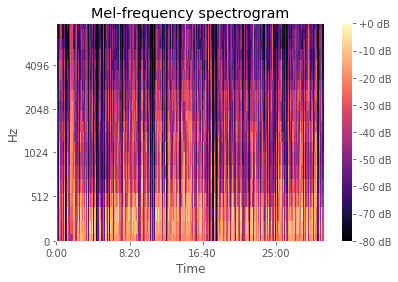

In [ ]:
y,sr = librosa.load('us_election_presidential_debate.mp3')
time_sec = round(librosa.get_duration(y,sr=sr))

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, fmax=8000)

fig, ax = plt.subplots()

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram');

In [ ]:
time_series_sec = np.linspace(0,time_sec,len(S_dB[0]))

In [ ]:
def convert_to_sec(time_string):
    try:
      time_s_list = time_string.split(':')
      
      if len(time_s_list)>2:
          date_time = datetime.datetime.strptime(time_string, "%H:%M:%S")
      else:
          date_time = datetime.datetime.strptime(time_string, "%M:%S")
    except Exception:
      return 0 
      
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    
    return a_timedelta.total_seconds()

In [ ]:
data = pd.read_csv('us_election_2020_1st_presidential_debate.csv')
minute_list = data.minute.tolist()

In [ ]:
time_data = list(map(convert_to_sec,minute_list))

for i in range(len(time_data)-1):
    if time_data[i] == time_data[i+1]:
        time_data[i+1] += 1

turn_index = time_data.index(0)
offset = time_data[turn_index-1] + 1

for j in range(turn_index,len(time_data)):
    time_data[j] += offset

data['Seconds'] = time_data

In [ ]:
data.head()

,speaker,minute,text,Seconds
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...,80.0
1,Chris Wallace,02:10,This debate is being conducted under health an...,130.0
2,Vice President Joe Biden,02:49,"How you doing, man?",169.0
3,President Donald J. Trump,02:51,How are you doing?,171.0
4,Vice President Joe Biden,02:51,I’m well.,172.0


In [ ]:
data.speaker.unique()

array(['Chris Wallace', 'Vice President Joe Biden',
       'President Donald J. Trump', 'Chris Wallace:'], dtype=object)

In [ ]:
new_data = data[data.Seconds<=time_series_sec.max()]
new_data.speaker.replace({'Chris Wallace:':'Chris Wallace'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
new_data.drop_duplicates(subset='speaker')

,speaker,minute,text,Seconds
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...,80.0
2,Vice President Joe Biden,02:49,"How you doing, man?",169.0
3,President Donald J. Trump,02:51,How are you doing?,171.0


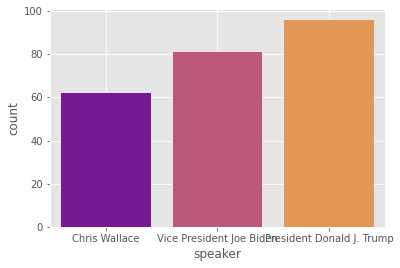

In [ ]:
sns.countplot(x=new_data.speaker,palette='plasma')
plt.grid(True)

In [ ]:
audio_data = pd.DataFrame(S_dB).T

In [ ]:
audio_data.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
78925,-23.540781,-29.869152,-33.253540,-48.787552,-50.790638,-55.075882,-58.180855,-54.047329,-58.472557,-59.650135,-56.945705,-52.850143,-50.357590,-58.817379,-61.036015,-65.970085,-67.571915,-59.890358,-58.267235,-63.953678
78926,-24.338354,-27.272274,-36.424652,-48.707146,-50.479362,-56.653610,-60.238792,-53.887589,-57.892422,-59.448681,-56.388748,-55.903320,-55.484413,-63.726189,-60.687164,-67.879074,-71.162903,-67.504990,-65.657104,-67.167587
78927,-27.052740,-25.285572,-37.268501,-53.318665,-53.910175,-56.830540,-61.206852,-58.729965,-58.086605,-58.373425,-57.178265,-60.149372,-62.210171,-68.002701,-63.907856,-71.812927,-74.612167,-74.269455,-70.641891,-70.549232
78928,-28.358324,-25.287811,-37.773109,-53.415787,-53.745110,-56.442547,-62.380230,-63.299782,-60.142223,-57.158703,-57.537395,-62.911690,-64.168533,-68.764389,-69.466766,-75.542854,-76.199844,-76.167923,-72.687523,-73.958984
78929,-29.106325,-27.038261,-41.510834,-52.434143,-54.528221,-56.821808,-61.748745,-63.342499,-59.858601,-58.049259,-61.247448,-65.130508,-66.213974,-68.611023,-69.794800,-73.201111,-74.523148,-74.223068,-74.282669,-74.999115


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit(audio_data)

PCA(n_components=3)

In [ ]:
pca_data = pd.DataFrame(pca.transform(audio_data))

In [ ]:
audio_time = np.array(pca_data.index.tolist())*new_data.Seconds.max()/np.array(pca_data.index.tolist()).max()
nd_time_list = [0]+new_data.Seconds.tolist()
CLASS = []
for j in range(len(audio_time)):
    time_j = audio_time[j]
    for i in range(1,len(nd_time_list)):
        start_i = nd_time_list[i-1]
        end_i = nd_time_list[i]
        if time_j>=start_i and time_j<=end_i:
            CLASS.append(new_data.loc[i-1].speaker)

In [ ]:
pca_data['speaker']=CLASS[0:len(pca_data)]
pca_data['Time']=audio_time
pca_data.head()

,0,1,2,speaker,Time
0,154.918777,6.513848,12.547825,Chris Wallace,0.000000
1,145.735382,1.412523,10.700298,Chris Wallace,0.023198
2,145.210068,1.648916,9.193157,Chris Wallace,0.046396
3,146.717194,3.493551,8.956697,Chris Wallace,0.069594
4,143.677734,4.163140,13.238743,Chris Wallace,0.092792


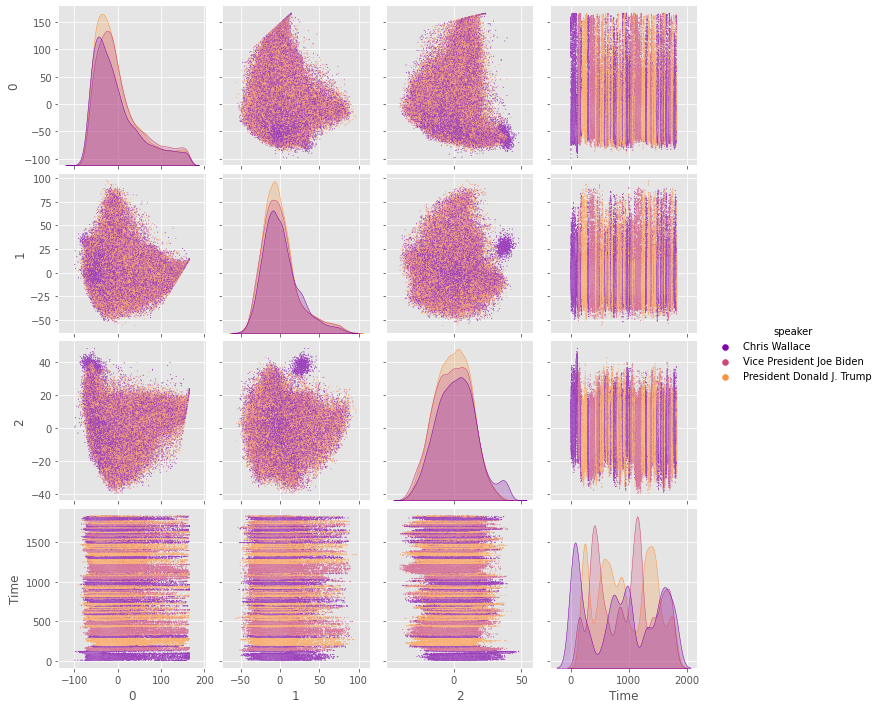

In [ ]:
sns.pairplot(pca_data,hue='speaker',plot_kws={'s':1},palette='plasma')

In [ ]:
from sklearn.feature_selection import mutual_info_classif as mi

In [ ]:
pca_data

,0,1,2,speaker,Time
0,154.918777,6.513848,12.547825,Chris Wallace,0.000000
1,145.735382,1.412523,10.700298,Chris Wallace,0.023198
2,145.210068,1.648916,9.193157,Chris Wallace,0.046396
3,146.717194,3.493551,8.956697,Chris Wallace,0.069594
4,143.677734,4.163140,13.238743,Chris Wallace,0.092792
...,...,...,...,...,...
78925,44.296391,-0.041518,-15.178584,President Donald J. Trump,1830.907208
78926,51.772820,-9.053226,-14.572285,President Donald J. Trump,1830.930406
78927,63.509819,-16.333960,-15.386052,President Donald J. Trump,1830.953604
78928,70.023331,-21.051733,-16.478809,President Donald J. Trump,1830.976802


In [ ]:
mi(X=pca_data[['Time',0,1,2]],y=pca_data['speaker'])

array([1.09082139, 0.00179884, 0.        , 0.00899889])

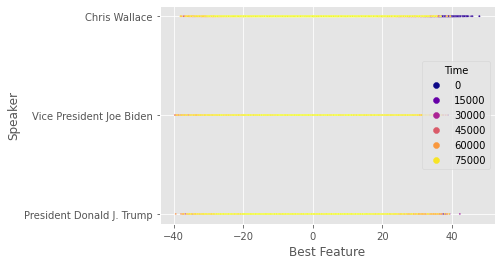

In [ ]:
plt.grid(True)
sns.scatterplot(x=pca_data[2],y=pca_data["speaker"],hue=pca_data.index,s=3,palette='plasma')
plt.legend(title='Time')
plt.xlabel('Best Feature');
plt.ylabel('Speaker');

In [ ]:
time_series_data = pca_data[['Time',2,'speaker']].rename(columns={2:'X'})

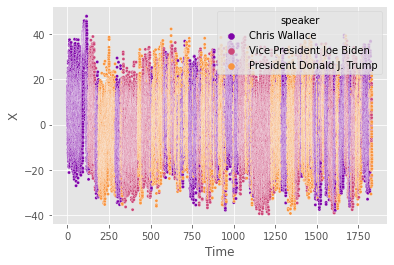

In [ ]:
sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
time_series_data['speaker']=le.fit_transform(time_series_data.speaker)

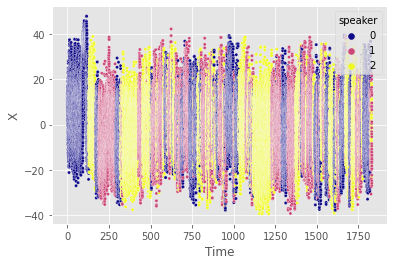

In [ ]:
sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [ ]:
encod_dic = {0:'Chris Wallace',2:'Vice President Joe Biden',1:'President Donald J. Trump'}

In [ ]:
X=time_series_data[['Time','X']]
y=time_series_data.speaker

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [ ]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [ ]:
from itertools import chain
x_new_train = list(map(lambda x:list(chain(*x)),x_train))

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="sigmoid")
svm.fit(x_new_train,y_train)

SVC(kernel='sigmoid')

In [ ]:
svm.score(list(map(lambda x:list(chain(*x)),x_train)),y_train)

0.38466272103672333

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
  
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN,Conv1D, BatchNormalization, ReLU

# CNN + LSTM
def make_model2(model=None):
  embed_dim = 128
  rnn_out = 196
  lstm_out = 196
  batch_size = 32
  dropout_rate = 0.5

  
  model = Sequential()
  
  model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
  model.add(BatchNormalization())
  model.add(ReLU())

  # model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
  model.add(LSTM(lstm_out))
  #model.add(SimpleRNN(rnn_out, activation="tanh", dropout=dropout_rate, recurrent_dropout=dropout_rate))
  model.add(Dense(200))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  return model

model = make_model2()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN

# RNN
def make_model2():
  embed_dim = 128
  rnn_out = 196
  lstm_out = 196
  batch_size = 32
  dropout_rate = 0.5

  model = Sequential()
  # model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
  model.add(SimpleRNN(rnn_out, activation="tanh", dropout=dropout_rate, recurrent_dropout=dropout_rate))
  model.add(Dense(200))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  return model

model = make_model2()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

# LSTM
def make_model3():
  embed_dim = 128
  lstm_out = 196
  batch_size = 32

  model = Sequential()
  # model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
  model.add(LSTM(lstm_out))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  return model

model = make_model3()

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', random_state=47,hidden_layer_sizes=200,max_iter=1000).fit(x_new_train, y_train)
clf.score(list(map(lambda x:list(chain(*x)),x_train)),y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.40757633346002786

In [ ]:
epochs = 50
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
691/691 [==============================] - 12s 12ms/step - loss: 0.9435 - sparse_categorical_accuracy: 0.5296 - val_loss: 0.9263 - val_sparse_categorical_accuracy: 0.5208 - lr: 0.0010
Epoch 2/50
691/691 [==============================] - 8s 11ms/step - loss: 0.8889 - sparse_categorical_accuracy: 0.5590 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.6007 - lr: 0.0010
Epoch 3/50
691/691 [==============================] - 8s 11ms/step - loss: 0.8723 - sparse_categorical_accuracy: 0.5699 - val_loss: 0.8216 - val_sparse_categorical_accuracy: 0.6017 - lr: 0.0010
Epoch 4/50
691/691 [==============================] - 7s 11ms/step - loss: 0.8534 - sparse_categorical_accuracy: 0.5806 - val_loss: 0.8231 - val_sparse_categorical_accuracy: 0.6040 - lr: 0.0010
Epoch 5/50
691/691 [==============================] - 8s 11ms/step - loss: 0.8405 - sparse_categorical_accuracy: 0.5900 - val_loss: 0.7988 - val_sparse_categorical_accuracy: 0.6271 - lr: 0.0010
Epoch 6/50
691/691 [=========

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

740/740 [==============================] - 3s 5ms/step - loss: 0.7660 - sparse_categorical_accuracy: 0.6268
Test accuracy 0.6268423199653625
Test loss 0.7660268545150757


In [ ]:
pred_test = pd.DataFrame(model.predict(x_test))

In [ ]:
pred_test = pred_test.rename(columns=encod_dic)

In [ ]:
pred_test.head()

In [ ]:
test_data = X_test.reset_index().drop('index',axis=1)
test_data['target']=y_test
test_data['Chris Wallace']=pred_test['Chris Wallace']
test_data['President Donald J. Trump']=pred_test['President Donald J. Trump']
test_data['Vice President Joe Biden']=pred_test['Vice President Joe Biden']

In [ ]:
target_list = test_data.target.tolist()
for t in range(len(target_list)):
    target_list[t]=encod_dic[target_list[t]]

In [ ]:
test_data['target']=target_list

In [ ]:
test_data = test_data.sort_values(by='Time')

In [ ]:
test_data

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title('Test Set Data')
sns.scatterplot(x=test_data.Time,y=test_data.X,s=10,hue=test_data.target,palette='plasma')
plt.grid(True)
plt.subplot(2,2,2)
plt.title('Chris Wallace Probability')
sns.scatterplot(x=test_data.Time,y=test_data.X,s=10,hue=test_data['Chris Wallace'])
plt.grid(True)
plt.subplot(2,2,3)
plt.title('Trump Probability')
sns.scatterplot(x=test_data.Time,y=test_data.X,s=10,hue=test_data['President Donald J. Trump'])
plt.grid(True)
plt.subplot(2,2,4)
plt.title('Biden Probability')
sns.scatterplot(x=test_data.Time,y=test_data.X,s=10,hue=test_data['Vice President Joe Biden'])
plt.grid(True)
plt.tight_layout()

In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [ ]:
def model_to_clf(input_data):
    pred_list = model.predict(input_data)
    return [np.argmax(p) for p in pred_list]

In [ ]:
cm=confusion_matrix(model_to_clf(x_test),y_test)

In [ ]:
cm_data = pd.DataFrame(cm,columns=[encod_dic[0],encod_dic[1],encod_dic[2]])

In [ ]:
cm_data.index = [encod_dic[0],encod_dic[1],encod_dic[2]]

In [ ]:
cm_data

In [ ]:
sns.heatmap(cm_data.astype(int), fmt='d', annot=True,cmap='plasma')
plt.yticks(rotation=0)
plt.xticks(rotation=0,fontsize=10)

In [ ]:
clf_report = classification_report(y_test,
                                   model_to_clf(x_test),
                                   labels= [0,1,2],
                                   target_names= [encod_dic[0],encod_dic[1],encod_dic[2]],
                                   output_dict=True)

In [ ]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='plasma')